In [32]:
import numpy as np
import matplotlib.pyplot as plt

from math import ceil, floor
from scipy.optimize import minimize
from tqdm import tqdm
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from clusterlensing import ClusterLensing
from astropy.cosmology import FlatLambdaCDM
import pandas as pd

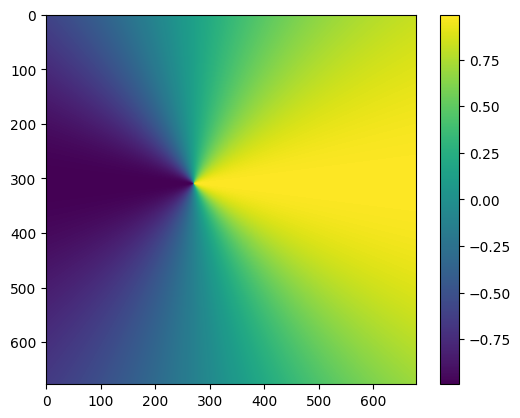

In [33]:
# use sie lens with similar values to verify the correctness of the model

#checking the vaildity of the source plane map

import matplotlib.pyplot as plt
# specify the choice of lens models #
lens_model_list = ['SIE']

# setup lens model class with the list of lens models #
lensModel = LensModel(lens_model_list=lens_model_list)

# define parameter values of lens models #
theta_E = 100                 #in pixel
len_coord = (270, 310)        #in pixel
kwargs_sie = {'theta_E': theta_E, 'e1':0, 'e2':0.2, 'center_x': len_coord[0], 'center_y': len_coord[1]}
kwargs_lens = [kwargs_sie]

# image plane coordinate #
size = 678
pixscale = 0.01
x_grid, y_grid = np.meshgrid(np.linspace(0, size-1, size), np.linspace(0, size-1, size))

# Flatten the grid for calculations
x_flat = x_grid.flatten()
y_flat = y_grid.flatten()

# Calculate convergence (kappa)
kappa = lensModel.kappa(x_flat, y_flat, kwargs_lens)

# Reshape back to 2D grid
#kappa_2d = kappa.reshape(x_grid.shape)

# ray-tracing to the source plane

alpha_x, alpha_y = lensModel.alpha(x_flat, y_flat, kwargs_lens)
# make beta_x and beta_y 2d

alpha_x_2d = alpha_x.reshape(x_grid.shape)
alpha_y_2d = alpha_y.reshape(x_grid.shape)

psi = lensModel.potential(x_flat, y_flat, kwargs_lens)
psi = psi.reshape(x_grid.shape)
psi_arcsec = psi * pixscale**2

alpha_x_arcsec = alpha_x_2d * pixscale
alpha_y_arcsec = alpha_y_2d * pixscale

plt.imshow(alpha_x_arcsec)   #assume this is in arcsec
plt.colorbar()


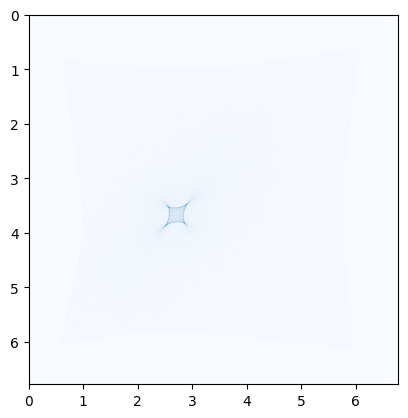

In [34]:
# illustrate the casutic
array_test = np.zeros([678,678])

for i in range(0, 678):
    for j in range(0, 678):
        ycoord = i-alpha_y_2d[i,j] # src coord
        xcoord = j-alpha_x_2d[i,j]
        if ycoord<0 or ycoord>677 or xcoord<0 or xcoord>677:
            continue
        xceil = ceil(xcoord)
        yceil = ceil(ycoord)
        xfloor = floor(xcoord)
        yfloor = floor(ycoord)
        if i%3==0 and j%3==0:
            array_test[yfloor,xfloor] += 1 
      
    
plt.imshow(array_test, cmap='Blues', extent=[0, 678* pixscale, 0, 678 * pixscale])
plt.gca().invert_yaxis()

In [35]:
beta = (270.8,305.4) #in pixel
z_s = 1.0
z_l = 0.5
cluster = ClusterLensing(alpha_x_arcsec, alpha_y_arcsec, psi_arcsec, z_l , z_s, pixscale, 678, beta[0]*pixscale, beta[1]*pixscale, diff_z = False)


Image 1 position: [1.89004964 3.71652211]
Predicted Image 1 position: [1.89007286 3.71656217]
Difference: 4.630982251838734e-05
Image 2 position: [1.94479608 2.53101305]
Predicted Image 2 position: [1.94481388 2.53097267]
Difference: 4.412589839201544e-05
Image 3 position: [3.25347808 3.7998399 ]
Predicted Image 3 position: [3.25345434 3.79987279]
Difference: 4.0568896105186414e-05
Image 4 position: [3.39460518 2.25510718]
Predicted Image 4 position: [3.39461185 2.25510164]
Difference: 8.669790190623747e-06


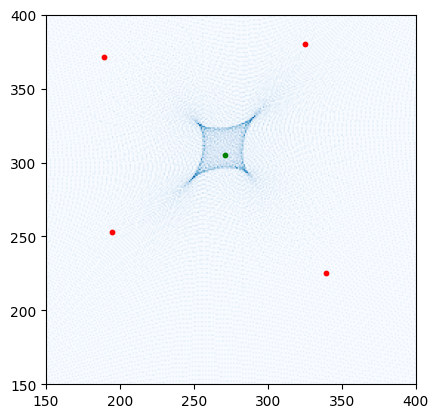

In [36]:


# lenstronomy
solver = LensEquationSolver(lensModel)
thetax, thetay = solver.image_position_analytical(beta[0], beta[1], kwargs_lens)

theta_analytical = [[] for _ in range(len(thetax))]

for i in range(len(thetax)):
    theta_analytical[i] = thetax[i], thetay[i]

theta_analytical = np.array(theta_analytical)
sorted_theta_analytical = sorted(theta_analytical * pixscale, key=lambda x: x[0])  # sort by x coordinate

# my class
theta_numerical = np.array(cluster.get_image_positions())
sorted_theta_numerical = sorted(theta_numerical, key=lambda x: x[0])  # sort by x coordinate
plt.scatter(theta_numerical[:,0] / pixscale, theta_numerical[:,1] / pixscale, color='blue', s=5, marker='x')
plt.scatter(thetax, thetay, color='red', s=10)
plt.scatter(beta[0], beta[1], color='green', s=10)
plt.imshow(array_test, cmap='Blues')
plt.gca().invert_yaxis()
plt.xlim(150,400)
plt.ylim(150,400)

for i in range(len(sorted_theta_analytical)):
    print(f'Image {i+1} position: {sorted_theta_numerical[i]}')
    print(f'Predicted Image {i+1} position: {sorted_theta_analytical[i]}')
    print(f'Difference: {np.sqrt((sorted_theta_numerical[i][0]-sorted_theta_analytical[i][0])**2 + (sorted_theta_numerical[i][1]-sorted_theta_analytical[i][1])**2)}')   


In [37]:


print("Numerical:")
mag_table = cluster.get_magnifications() #output a dataframe
print(mag_table)

# Analytical magnifications
data_analytical = []
print("Analytical:")
for i in range(len(thetax)):
    x, y = thetax[i], thetay[i]
    mag = lensModel.magnification(thetax[i], thetay[i], kwargs_lens)
    data_analytical.append({'x': x * pixscale, 'y': y * pixscale, 'magnification': mag})
    

table_analytical = pd.DataFrame(data_analytical)
pd.options.display.float_format = '{:.12f}'.format
table_analytical = table_analytical.sort_values(by=['x', 'y']).reset_index(drop=True)
print(table_analytical)

Numerical:
               x              y   magnification
0 1.890049635107 3.716522111744  5.254523470194
1 1.944796081479 2.531013049434 -3.533013046579
2 3.253478083509 3.799839896264 -2.748526740378
3 3.394605181785 2.255107175583  3.970773478045
Analytical:
               x              y   magnification
0 1.890072864801 3.716562173896  5.159135846961
1 1.944813875035 2.530972670217 -3.573014363840
2 3.253454339765 3.799872791107 -2.768917175999
3 3.394611850937 2.255101636058  3.976174588803


In [38]:
# default time delay
print("Numerical:")
dt = cluster.get_time_delays()
print(dt)


'''data_dt = []
for i in range(len(theta_numerical)):
    x, y = theta_numerical[i]
    delay = dt[i]       # in days
    data_dt.append({'x': x, 'y': y, 'delta_t': delay})

table = pd.DataFrame(data_dt)
pd.options.display.float_format = '{:.12f}'.format
table = table.sort_values(by=['x', 'y']).reset_index(drop=True)
print(table)'''


# restore the lens model in arcsec
kwargs_sie1 = {'theta_E': theta_E * pixscale, 'e1':0, 'e2':0.2, 'center_x': len_coord[0] * pixscale, 'center_y': len_coord[1] * pixscale}

kwargs_lens1 = [kwargs_sie1]


lensModel = LensModel(lens_model_list=lens_model_list, z_source=z_s, z_lens=z_l)
print("Analytical:")
thetax, thetay = solver.image_position_analytical(beta[0]* pixscale, beta[1]*pixscale, kwargs_lens1)
t_analytical = lensModel.arrival_time(thetax , thetay , kwargs_lens1, x_source=beta[0] * pixscale, y_source=beta[1] * pixscale)
dt_analytical = np.zeros(len(theta_numerical))
for i in range(len(thetax)):
    dt_analytical[i] = t_analytical[i] - t_analytical[0]

data_dt_analytical = []
for i in range(len(thetax)):
    x, y = theta_analytical[i] * pixscale
    delay = dt_analytical[i]    # in days
    data_dt_analytical.append({'theta_x': x, 'theta_y': y, 'delta_t': delay})

table1 = pd.DataFrame(data_dt_analytical)
pd.options.display.float_format = '{:.12f}'.format
print(table1)

Numerical:
         theta_x        theta_y       d_fermat   delta_t(days)
0 3.394605181741 2.255107175586 0.000000000000  0.000000000000
1 1.890049635097 3.716522111751 0.080107437684  9.889701151673
2 1.944796081510 2.531013049396 0.151120138380 18.656607298655
3 3.253478083482 3.799839896316 0.200102039623 24.703690804803
Analytical:
         theta_x        theta_y         delta_t
0 3.394611850937 2.255101636058  0.000000000000
1 1.890072864801 3.716562173896 10.229233228262
2 1.944813875035 2.530972670217 19.297979068491
3 3.253454339765 3.799872791107 25.552987224940


In [39]:
#test multiple source plane lensing code
# assume the default lens and source position are z_l = 0.5, z_s = 1.0 and thete_E = 1.0
z_l = 0.5
z_s = 2.0

#numerical stuffs
cluster_mp = ClusterLensing(alpha_x_arcsec, alpha_y_arcsec, psi_arcsec, z_l , z_s, pixscale, 678, beta[0]*pixscale, beta[1]*pixscale, diff_z = True)
print("Numerical:")
dt = cluster_mp.get_time_delays()
print(dt)

# analytical stuffs
from astropy.cosmology import FlatLambdaCDM
cosmos = FlatLambdaCDM(H0=70, Om0=0.3)

D_S1 = cosmos.angular_diameter_distance(1.0)
D_S2 = cosmos.angular_diameter_distance(z_s)
D_LS1 = cosmos.angular_diameter_distance_z1z2(z_l, 1.0)
D_LS2 = cosmos.angular_diameter_distance_z1z2(z_l, z_s)
factor =  D_LS1 * D_S2 / D_S1 / D_LS2
kwargs_sie2 = {'theta_E': theta_E*factor * pixscale, 'e1':0, 'e2':0.2, 'center_x': len_coord[0]* pixscale, 'center_y': len_coord[1]* pixscale}
kwargs_lens_mp = [kwargs_sie2]
lensModel2 = LensModel(lens_model_list=lens_model_list, z_source=z_s, z_lens=z_l)
solver2 = LensEquationSolver(lensModel2)

print("Analytical:")

thetax, thetay = solver2.image_position_analytical(beta[0]* pixscale, beta[1]* pixscale, kwargs_lens_mp)
t_analytical = lensModel2.arrival_time(thetax, thetay, kwargs_lens_mp, x_source=beta[0] * pixscale, y_source=beta[1] * pixscale)
min_t = min(t_analytical)
dt_analytical = np.zeros(len(theta_numerical))
for i in range(len(thetax)):
    dt_analytical[i] = t_analytical[i] - min_t
data_dt_analytical = []
for i in range(len(thetax)):
    x, y = thetax[i] , thetay[i]
    delay = dt_analytical[i]    # in days
    data_dt_analytical.append({'theta_x': x, 'theta_y': y, 'delta_t': delay})

table1 = pd.DataFrame(data_dt_analytical)
pd.options.display.float_format = '{:.12f}'.format
print(table1)



Numerical:
         theta_x        theta_y             d_fermat  delta_t(days)
0 3.154453150482 2.502438144086                  0.0 0.000000000000
1 2.129252069313 3.461333758998  0.05365444859546581 4.465565625017
2 2.155802537145 2.755960206875  0.07453331460295679 6.203277012853
3 3.042739619122 3.581564057578  0.10710923435689465 8.914513662646
Analytical:
         theta_x        theta_y        delta_t
0 3.154471165730 2.502438002715 0.000000000000
1 2.129257156405 3.461353325391 4.616921928500
2 2.155796077045 2.755926847696 6.414598954893
3 3.042743812392 3.581585949366 9.217687323561


In [50]:
# population of time delays
# test the time delay population
import numpy as np

def generate_random_coordinates(num_points, x_bound, y_bound):
    """
    Generate a list of 2-element arrays containing random coordinates within the specified bounds.

    Parameters:
    ---------------
    num_points: int
        The number of random points to generate.
    x_bound: tuple
        A tuple specifying the (min, max) bounds for the x coordinates.
    y_bound: tuple
        A tuple specifying the (min, max) bounds for the y coordinates.

    Returns:
    ---------------
    List of 2-element arrays containing random coordinates.
    """
    x_coords = np.random.uniform(x_bound[0], x_bound[1], num_points)
    y_coords = np.random.uniform(y_bound[0], y_bound[1], num_points)
    coordinates = np.column_stack((x_coords, y_coords))
    return coordinates

# generate beta population in arcsec
num_points = 100
len_coord_arcsec = (len_coord[0] * pixscale, len_coord[1] * pixscale)
x_bound = (len_coord_arcsec[0] - 0.5 , len_coord_arcsec[0] + 0.5) 
y_bound = (len_coord_arcsec[1] - 0.5, len_coord_arcsec[1] + 0.5)  
z_l = 0.5
z_s = 1.0
beta_pop = generate_random_coordinates(num_points, x_bound, y_bound)

dt_pop = []
for i in tqdm(range(num_points)):
    beta = beta_pop[i]
    cluster_mp = ClusterLensing(alpha_x_arcsec, alpha_y_arcsec, psi_arcsec, z_l , z_s, pixscale, 678, beta[0], beta[1], diff_z = False)
    dt = cluster_mp.get_time_delays()
    dt_value = dt['delta_t(days)'].values.tolist()
    dt_value = [value for value in dt_value if value != 0]
    dt_pop.append(dt_value)
    #print(dt['delta_t(days)'])
print(dt_pop)

100%|██████████| 100/100 [01:46<00:00,  1.07s/it]

[[69.95770210857852], [129.90540075949417], [120.04167987423719], [110.79364296933504], [77.19036791516449], [129.16046608428667], [9.891615960138182, 17.86761480882048, 25.721117263021505], [62.11259985333051], [], [], [132.17619085892503], [147.39695797576857], [67.25072779096622], [90.65848332611758], [71.45691438938411], [], [101.98172225808403], [91.42446722491874], [68.09921229311286], [8.127183670324431, 18.056921013845393, 23.20880865125411], [107.17054496786037], [86.30714808213354], [112.84705242879588], [77.6547393824962], [67.61443129519331], [125.29197106007638], [50.384991354018396], [8.575802398334085, 12.726915791930214, 32.12583087235012], [95.17111853067355], [], [2.080145713072024, 2.133890674554109, 2.5309617146717365, 50.494941109027465], [143.1855528232051], [118.54369582327867], [61.87643216011375], [80.36348050089887], [75.79100178718777], [], [18.188143811600934, 22.482269378461364, 31.472843892376492], [100.4262303456672], [59.67747468188124], [8.9011228240809

[ 69.95770211 129.90540076 120.04167987 110.79364297  77.19036792
 129.16046608   9.89161596  17.86761481  25.72111726  62.11259985
 132.17619086 147.39695798  67.25072779  90.65848333  71.45691439
 101.98172226  91.42446722  68.09921229   8.12718367  18.05692101
  23.20880865 107.17054497  86.30714808 112.84705243  77.65473938
  67.6144313  125.29197106  50.38499135   8.5758024   12.72691579
  32.12583087  95.17111853   2.08014571   2.13389067   2.53096171
  50.49494111 143.18555282 118.54369582  61.87643216  80.3634805
  75.79100179  18.18814381  22.48226938  31.47284389 100.42623035
  59.67747468   8.90112282  19.57386959  22.40376117 108.93126425
  51.49016834 121.46408203  67.90098219 131.62265712 123.86810523
 113.52887035  53.00406324 123.94857023 110.9973431  124.71980792
 106.98116532  59.68690642  96.57462539 120.72472299 106.65464682
   1.73021617  59.58538659  75.05339421 113.4669799    9.005541
  12.58317037  33.23133747 107.86839359  89.2846858   15.7952749
  20.20929777 

(array([4., 5., 3., 5., 4., 1., 3., 3., 0., 4., 2., 3., 6., 5., 5., 5., 1.,
        4., 2., 3., 3., 5., 7., 4., 9., 3., 2., 2., 2., 2.]),
 array([  1.73021617,   6.68521396,  11.64021174,  16.59520953,
         21.55020732,  26.5052051 ,  31.46020289,  36.41520067,
         41.37019846,  46.32519624,  51.28019403,  56.23519181,
         61.1901896 ,  66.14518738,  71.10018517,  76.05518295,
         81.01018074,  85.96517852,  90.92017631,  95.87517409,
        100.83017188, 105.78516966, 110.74016745, 115.69516523,
        120.65016302, 125.6051608 , 130.56015859, 135.51515637,
        140.47015416, 145.42515194, 150.38014973]),
 <BarContainer object of 30 artists>)

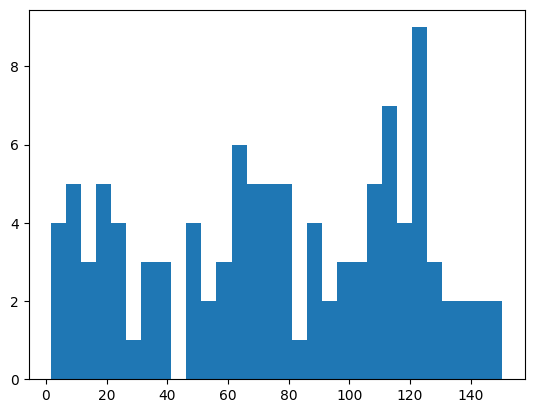

In [59]:
dt_pop_hist = np.concatenate(dt_pop)
print(dt_pop_hist)
plt.hist(dt_pop_hist, bins=30)

In [30]:
beta_test = (2.75706612, 3.13571632)
z_l = 0.5
z_s = 1.0
test = ClusterLensing(alpha_x_arcsec, alpha_y_arcsec, psi_arcsec, z_l , z_s, pixscale, 678, beta_test[0], beta_test[1], diff_z = False)
print(test.get_time_delays())

         theta_x        theta_y       d_fermat   delta_t(days)
0 3.631838551006 2.558346382515 0.000000000000  0.000000000000
1 2.205921594261 4.025102408389 0.030883330426  3.812715988775
2 3.351753573730 3.840494133003 0.094297006090 11.641480949704
3 2.070870657946 2.520391392420 0.214983536781 26.540892990185
